In [38]:
%load_ext autoreload
%autoreload 2
import jax
from jax.random import split, PRNGKey, normal
from jax import vmap
from jax import numpy as jnp
from aritmetic_bayesian_network import bayesian_network, InferenceForBayesianNetwork
from train_aritmetic_bayesian_network import initialize_model
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as onp
import equinox as eqx
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
  def sample_obs(means, class_label, k):
    # means = jnp.stack([jnp.arange(3)]*2,axis=1)/3
    # return tfd.MultivariateNormalDiag(
    #   loc = means[class_label],
    #   scale_diag=jnp.ones_like(means[class_label])/10.0
    # ).sample(seed=k)
    means = jnp.arange(3)/3
    return (normal(k)/10.0 + means[class_label])[None]
    
    # return jnp.stack([class_label,class_label],dtype=jnp.float32)
  
  def sample(k, *, max_num_mixtures=3, dims=2, num_obs=100):
    ks = split(k, 5)
    num_mixtures = tfd.Categorical(
        probs=jnp.ones((max_num_mixtures,)) / max_num_mixtures
    ).sample(seed=ks[0])
    
    means = tfd.Uniform(low=-1.0, high=1.0).sample(
        seed=ks[1], sample_shape=(max_num_mixtures, dims)
    )
    
    class_labels_probs = jnp.where(
        jnp.arange(max_num_mixtures) <= num_mixtures,
        jnp.ones((max_num_mixtures,)),
        jnp.zeros((max_num_mixtures,)),
    )/(num_mixtures+1)
    
    class_labels = tfd.Categorical(probs=class_labels_probs).sample(
        seed=ks[3], sample_shape=(num_obs,)
    )
    
    obs = jax.vmap(sample_obs, in_axes=(None,None,0))(
      means,num_mixtures,split(ks[4],num_obs)
    )
    
    return obs, num_mixtures

In [40]:
test_obs, test_b = jax.vmap(sample)(split(PRNGKey(5847),1000))

In [52]:
test_obs.shape

(1000, 100, 1)

In [47]:
obs_size = 100
def sample(k,*, max_num_mixtures=6):
    """sample a bernoulli and then sample the normal based on the value of the bernoulli.
    Augment the flow with standard normals to make it easier to learn.
    """
    ks = split(k, 3)
    # b = bernoulli(ks[0], 0.5)
    b = tfd.Categorical(
        probs=jnp.ones((max_num_mixtures,)) / max_num_mixtures
    ).sample(seed=ks[0])
    s = normal(ks[1],shape=(obs_size,1))
    s /= 10.0
    s += jnp.arange(max_num_mixtures)[b]/max_num_mixtures
    return s, jnp.int32(b)

In [51]:
vmap(sample)(split(PRNGKey(0),200))[0].shape

(200, 100, 1)

In [138]:
k = PRNGKey(2)
obs_size = 100
max_num_mixtures = 6
dims = 2
ks = split(k, 4)
b = tfd.Categorical(
    probs=jnp.ones((max_num_mixtures,)) / max_num_mixtures
).sample(seed=ks[0])
means = tfd.Uniform(low=-1.0, high=1.0).sample(
    seed=ks[1], sample_shape=(max_num_mixtures, dims)
)
means = jnp.stack([jnp.arange(max_num_mixtures)]*dims,axis=1)/max_num_mixtures
# means = jax.random.shuffle(ks[3],means,axis=0)

class_labels_probs = jnp.where(
    jnp.arange(max_num_mixtures) < b,
    jnp.ones((max_num_mixtures,)),
    jnp.zeros((max_num_mixtures,)),
)

class_labels = tfd.Categorical(probs=class_labels_probs).sample(
    seed=ks[3], sample_shape=(obs_size,)
)
s = normal(ks[2],shape=(obs_size,dims))
s /= 10.0

mean = (jnp.stack([jnp.arange(max_num_mixtures)]*dims,axis=1)/max_num_mixtures)[class_labels].reshape(-1,dims)

s+=mean

In [140]:
mean

Array([[0.16666667, 0.16666667],
       [0.33333334, 0.33333334],
       [0.5       , 0.5       ],
       [0.        , 0.        ],
       [0.6666667 , 0.6666667 ],
       [0.        , 0.        ],
       [0.6666667 , 0.6666667 ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.33333334, 0.33333334],
       [0.        , 0.        ],
       [0.16666667, 0.16666667],
       [0.        , 0.        ],
       [0.33333334, 0.33333334],
       [0.33333334, 0.33333334],
       [0.33333334, 0.33333334],
       [0.6666667 , 0.6666667 ],
       [0.5       , 0.5       ],
       [0.33333334, 0.33333334],
       [0.16666667, 0.16666667],
       [0.16666667, 0.16666667],
       [0.6666667 , 0.6666667 ],
       [0.16666667, 0.16666667],
       [0.6666667 , 0.6666667 ],
       [0.        , 0.        ],
       [0.6666667 , 0.6666667 ],
       [0.6666667 , 0.6666667 ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.6666667 , 0.6666667 ],
       [0.

(100, 2)

In [100]:
obs_size = 100
ks = split(k, 3)
# b = bernoulli(ks[0], 0.5)
b = tfd.Categorical(
    probs=jnp.ones((max_num_mixtures,)) / max_num_mixtures
).sample(seed=ks[0])
s = normal(ks[1],shape=(obs_size,1))
s /= 10.0
s += jnp.arange(max_num_mixtures)[b]/max_num_mixtures
s.mean()

Array(0.33733204, dtype=float32)

In [101]:
jnp.arange(max_num_mixtures)[b], jnp.stack([jnp.arange(max_num_mixtures)]*dims,axis=1)[b], b

(Array(2, dtype=int32), Array([2], dtype=int32), Array(2, dtype=int32))

In [67]:
m_cfg = dict(
    key = PRNGKey(0),
    num_augments = 9,
    width_size = 128,
    num_blocks = 1,
    depth = 3,
)
m = initialize_model(
    model_cfg=m_cfg,
    load_idx=0,
    chkpt_folder="aritmetic_bayesian_chkpts/",
)

In [68]:
ks = split(PRNGKey(5327),20000)
*all_z_batches, x0_b, x1_b = vmap(bayesian_network)(ks[:10000])
all_z_batches_hat = vmap(m.rsample)(x0_b,x1_b,ks[10000:])

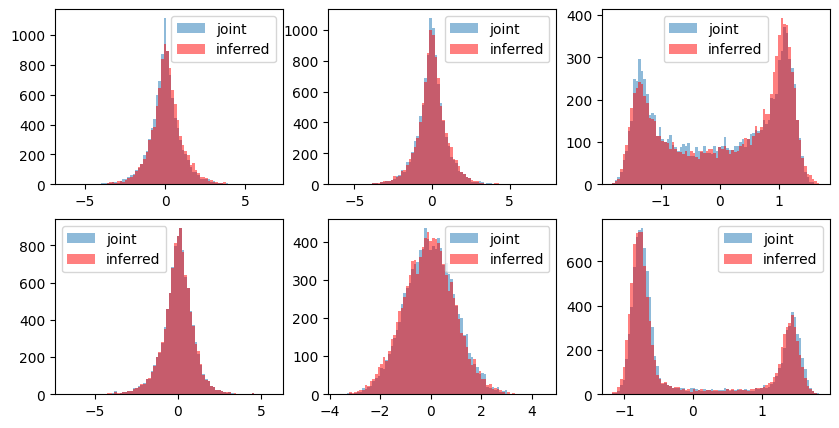

In [69]:
fig, axs = plt.subplots(2,3, figsize=(10,5))
for i,(z,z_) in enumerate(zip(all_z_batches,all_z_batches_hat)):
    col = i % 3
    row = 0 if i <= 2 else 1
    _ ,bins, _ = axs[row,col].hist(onp.array(z), bins = 80, alpha=0.5, label='joint')
    _ = axs[row,col].hist(onp.array(z_), bins = bins, alpha=0.5, color='red', label='inferred')
    axs[row,col].legend()



In [74]:
@eqx.filter_jit
def threshold(T,u):
    return T - jnp.log(1+jnp.exp(T-u))

In [2]:
%load_ext autoreload
%autoreload 2
from gaussian_mixture import gaussian_mixture, InferenceGaussianMixture
from train_gaussian_mixture import evaluate, initialize_optim, make_step
from utils import AttrDict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
num_mixtures, means, cov_terms, class_labels, obs = vmap(gaussian_mixture)(split(PRNGKey(6),10))

In [4]:
m = InferenceGaussianMixture(key=PRNGKey(1))
opt_c = AttrDict(
        max_lr=0.01,
        num_steps=int(10000),
        pct_start=0.01,
        div_factor=1e1,
        final_div_factor=1e1,
        weight_decay=0.0005,
        gradient_clipping=5.0,
    )
optim, opt_state = initialize_optim(opt_c, m)
l, m, opt_state, k, norm = make_step(m, opt_state, PRNGKey(4), 10)


NameError: name 'optim' is not defined

In [5]:
m = eqx.tree_inference(m, value=True)
log = evaluate(m, PRNGKey(0), 10)
m = eqx.tree_inference(m, value=False)

In [6]:
jax.tree_util.tree_map(lambda x: x.item(), log)

{'fit_covs': 0.5242633819580078,
 'fit_means': 0.46661925315856934,
 'fit_num_mixtures': 0.10000000149011612}

In [19]:
x = cov_terms[0]
x_hat = cov_terms_hat[0]
num_mixtures = num_mixtures[0]


In [27]:
jnp.arange(6) < num_mixtures
abs_dist = jnp.where(
        jnp.arange(6) < num_mixtures, jnp.abs(x - x_hat).sum(axis=1), 0.0
    ).sum()
abs_dist,jnp.abs(x - x_hat).sum(axis=1)

(Array(3.4896898, dtype=float32),
 Array([2.0948033, 1.3948865, 2.4763658, 2.0054665, 3.584384 , 5.116962 ],      dtype=float32))